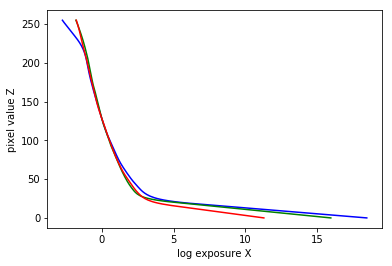

In [94]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
"""
IMG_LIST = ['pic/1_4s.JPG' , 'pic/1_10s.JPG' , 'pic/1_25s.JPG',
            'pic/1_64s.JPG', 'pic/1_128s.JPG', 'pic/1_320s.JPG','pic/1_640s.JPG',
            'pic/1_800s.JPG', 'pic/1_1600s.JPG','pic/1_3200s.JPG']
exposure_times = np.array([1/4, 1/10, 1/25, 1/64, 1/128, 1/320,1/640,
                           1/800, 1/1600, 1/3200], dtype=np.float32)
"""
"""
IMG_LIST = ['exposures/0.8s.jpg','exposures/10s.jpg','exposures/13s.jpg','exposures/1_3s.jpg',
            'exposures/1_4s.jpg','exposures/1_60s.jpg','exposures/1_80s.jpg','exposures/1s.jpg',
            'exposures/3.2s.jpg','exposures/4s.jpg']
exposure_times = np.array([0.8,10,13,1/3,1/4,1/60,1/80,1,3.2,4])
"""
IMG_LIST = ['Memorial_SourceImages/memorial0061.png','Memorial_SourceImages/memorial0062.png','Memorial_SourceImages/memorial0063.png',
            'Memorial_SourceImages/memorial0064.png','Memorial_SourceImages/memorial0065.png','Memorial_SourceImages/memorial0066.png',
            'Memorial_SourceImages/memorial0067.png','Memorial_SourceImages/memorial0068.png','Memorial_SourceImages/memorial0069.png',
            'Memorial_SourceImages/memorial0070.png','Memorial_SourceImages/memorial0071.png','Memorial_SourceImages/memorial0072.png',
            'Memorial_SourceImages/memorial0073.png','Memorial_SourceImages/memorial0074.png']
exposure_times = np.array([0.03125,0.0625,0.125,0.25,0.5,1,2,4,8,16,32,64,128,256])
def loadImgs():
    img_b = []
    img_g = []
    img_r = []
        
    for img in IMG_LIST:
        img = cv2.imread(img)
        img_b.append(img[:,:,0])
        img_r.append(img[:,:,1])
        img_g.append(img[:,:,2])
    return img_b, img_r, img_g

def getPixelVal(Img, Map):
    valMap = []
    for img in Img:
        tmp = list()
        for i in Map:
            tmp.append(img[int(i%img.shape[0]), int(i/img.shape[0])])
        valMap.append(tmp)
    return valMap

def genCompPixel(imgB, imgG, imgR):
    sampleMap = []
    sampleNum = 100

    sampleImg = imgR[len(imgR)//2]
    size = sampleImg.shape[0] * sampleImg.shape[1]
    while len(sampleMap) < sampleNum:
        i = random.randint(0, size - 1)
        sampleMap.append(i)

    return getPixelVal(imgB,sampleMap), getPixelVal(imgG,sampleMap), getPixelVal(imgR,sampleMap)

def CalCRC(Z, B, l, w):
    z_max = 256

    # Number of images
    p = np.size(Z, 0)

    # Number of samples
    n = np.size(Z, 1)

    A = np.zeros(shape=(n * p + z_max + 1, z_max + n), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data-fitting equations
    k = 0
    for i in range(n):
        for j in range(p):
            z = Z[j][i]
            wij = w[z]
            A[k][z] = wij
            A[k][z_max + i] = -wij
            b[k] = wij * B[j]
            k += 1

    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1

    # Include the smoothness equations
    for i in range(z_max - 1):
        A[k][i] = l * w[i+1]
        A[k][i+1] = -2 * l * w[i+1]
        A[k][i+2] = l * w[i+1]
        k += 1

    # Solve the system using SVD
    pseudo_A = np.linalg.pinv(A)
    x = np.dot(pseudo_A, b)

    g = x[0:z_max]
    lE = x[z_max:np.size(x, 0)]

    return g

def genRadMap(imgList, g, B, w):
    imgShape = imgList[0].shape
    imgRadianceMap = np.zeros(imgList[0].shape, dtype=np.float64)

    numImages = len(imgList)
    for i in range(imgShape[0]):
        for j in range(imgShape[1]):
            gz = list()
            wz = list()

            for k in range(0, numImages):
                gz.append(g[imgList[k][i, j]][0])
                wz.append(w[imgList[k][i, j]])

            gz = np.asarray(gz)
            wz = np.asarray(wz)

            sum_w = np.sum(wz)
            if sum_w > 0:
                imgRadianceMap[i, j] = np.sum(wz*(gz-B)/sum_w)
            else:
                imgRadianceMap[i, j] = gz[numImages//2]-B[numImages//2]
    return imgRadianceMap

def drawCRC(crcB, crcG, crcR):
    plt.figure()
    plt.plot(crcB, range(256), 'blue')
    plt.plot(crcG, range(256), 'green')
    plt.plot(crcR, range(256), 'red')
    plt.ylabel('pixel value Z')
    plt.xlabel('log exposure X')
    plt.savefig('CRC.png')

def main():
    img = cv2.imread(IMG_LIST[0])
    shape = img.shape
    width = shape[0]
    height = shape[1]

    imgListB, imgListG, imgListR = loadImgs()
    z_b, z_g, z_r = genCompPixel(imgListB, imgListG, imgListR)

    B = [math.log(e) for e in exposure_times]
    w = [z if z <= 127 else 255 - z for z in range(256)]

    # calculate Camera Response Curve
    L = 50
    crcB = CalCRC(z_b, B, L, w)
    crcG = CalCRC(z_g, B, L, w)
    crcR = CalCRC(z_r, B, L, w)
    blueCurve = np.exp(genRadMap(imgListB, crcB, B, w))
    greenCurve = np.exp(genRadMap(imgListG, crcG, B, w))
    redCurve = np.exp(genRadMap(imgListR, crcR, B, w))
    drawCRC(crcB, crcG, crcR)

    hdr = np.zeros(shape, 'float32')
    hdr[..., 0] = np.reshape(blueCurve, (width, height))
    hdr[..., 1] = np.reshape(greenCurve, (width, height))
    hdr[..., 2] = np.reshape(redCurve, (width, height))

    cv2.imwrite('out.hdr', hdr)
    normalize = lambda zi: (zi - zi.min() / zi.max() - zi.min())
    z_disp = normalize(np.log(hdr))

    # Tonemap using Drago's method to obtain 24-bit color image
    cv2.imwrite('hdr_image.jpg', (z_disp/z_disp.max())*255)

if __name__ == "__main__":
    main()

In [ ]:
"""
#產生50個點(i,j) seed = i,j
i = 1
j = 2
np.random.seed(seed=i)
ipixel = np.random.randint(low=0,high=4096,size=n)
np.random.seed(seed=j)
jpixel = np.random.randint(low=0,high=2730,size=n)

def open_img(img_name):
    img = Image.open(img_name)
    print("height =",img.height,"width =",img.width)
    return img.load()

pix1s = open_img(img_name[0])
pix2s = open_img(img_name[1])
pix4s = open_img(img_name[2])
pixel = [pix1s,pix2s,pix4s]
        
def gslove(Z,l,B,w):
    A_matrix = np.zeros((n*p+256+1,n+256))
    b_matrix = np.zeros((A_matrix.shape[0],1))
    
    k = 0
    for i in range(n): #第幾張圖片
        for j in range(p):     #第幾個 pixel number
            z = Z[j][i]
            wij = w[z]
            A_matrix[k][z] = wij
            A_matrix[k][256 + i] = -wij
            b_matrix[k] = wij * B[j]
            k += 1
            #A_matrix[k][pix1s[int(ipixel[0]),int(jpixel[0])][0]]= 1
            #A_matrix[k+1][pix2s[int(ipixel[0]),int(jpixel[0])][0]] = 1
            #A_matrix[k+2][pix4s[int(ipixel[0]),int(jpixel[0])][0]]= 1  
    A_matrix[k][128] = 1
    k += 1
    # Include the smoothness equations
    for i in range(255):
        A_matrix[k][i] = l * w[i+1]
        A_matrix[k][i+1] = (-2) * l *w[i+1]
        A_matrix[k][i+2] = l * w[i+1]
        k += 1
    # Solve the system using SVD
    pseudo_A_matrix = np.linalg.pinv(A_matrix)  # 原式 Ax = b
    x = np.dot(pseudo_A_matrix,b_matrix) #x = pseudo_A * b
    g = x[0:256] #g1 g2 ... gn
    return g

def Constructing_HDR_radiance_map(R_g,G_g,B_g,p,height,width,times):
    radiance_map = Image.new('RGB',(height,width))
    radiance_pixel = radiance_map.load()
    for i in range(width):
        for j in range(height):
            w_Z_sum = 0
            w_Z_g_R_lnt = 0
            w_Z_g_G_lnt = 0
            w_Z_g_B_lnt = 0
            for num in range(1): #第幾張 pic
                w = weight_function(pixel[num][i,j][0])
                
                w_Z_sum += w
                w_Z_g_R_lnt += w * ( R_g[pixel[num][i,j][0]] - np.log(times[num]) )
                w_Z_g_G_lnt += w * ( G_g[pixel[num][i,j][1]] - np.log(times[num]) )
                w_Z_g_B_lnt += w * ( B_g[pixel[num][i,j][2]] - np.log(times[num]) )
                
                radiance_map.putpixel((i,j),(np.exp(w_Z_g_R_lnt/w_Z_sum),
                                             np.exp(w_Z_g_G_lnt/w_Z_sum),
                                             np.exp(w_Z_g_B_lnt/w_Z_sum)))
                
    return radiance_map


def main():
    B = [math.log(t) for t in times]
    w = [z if z <= 127 else 255 - z for z in range(256)
    R_g = gslove(ipixel,jpixel,0,1)
    G_g = gslove(ipixel,jpixel,1,1)
    B_g = gslove(ipixel,jpixel,2,1)
    Constructing_HDR_radiance_map(R_g,G_g,B_g,p,2730,4096,times)
if __name__ == "__main__":
    main()
"""